In [1]:
import matplotlib.pyplot as plt      
from mpl_toolkits import mplot3d
import os
import sys
import glob
import time
import shutil
import gym
from gym import error, spaces, utils
import numpy as np
import math

In [2]:
import gym_fish

In [3]:
from gym_fish.envs.lib import pyflare as fl

In [4]:
gpuId = 0
control_dt=0.2
theta = np.array([90,90])
phi = np.array([0,0])
radius=1.0
max_time = 10
action_max= 10
done_dist = 0.15
dist_distri_param =np.array([0,0.0])
wc = 0.0*np.array([1.0,0.5])
wp = 1.0*np.array([0.0,1.0])
wa = 1.0

couple_mode =  fl.COUPLE_MODE.TWO_WAY

In [5]:

env=gym.make('fish-basic-v0',
             env_json='../assets/env_file/env_basic.json',
                  gpuId=gpuId,
                        couple_mode=couple_mode,
                         control_dt=control_dt,
                         theta = theta,
             phi = phi,
                        radius=radius,
             action_max=action_max,
                        max_time=max_time,
                        wp=wp,wc=wc,wa=wa,
                       done_dist=done_dist,dist_distri_param=dist_distri_param
                   )

visulization data save folder /home/liuwj/codes/pytorch_fish/scripts/gym-fish/gym_fish/envs/data/vis_data/


/home/liuwj/test_env/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [6]:
%matplotlib notebook

<IPython.core.display.Javascript object>


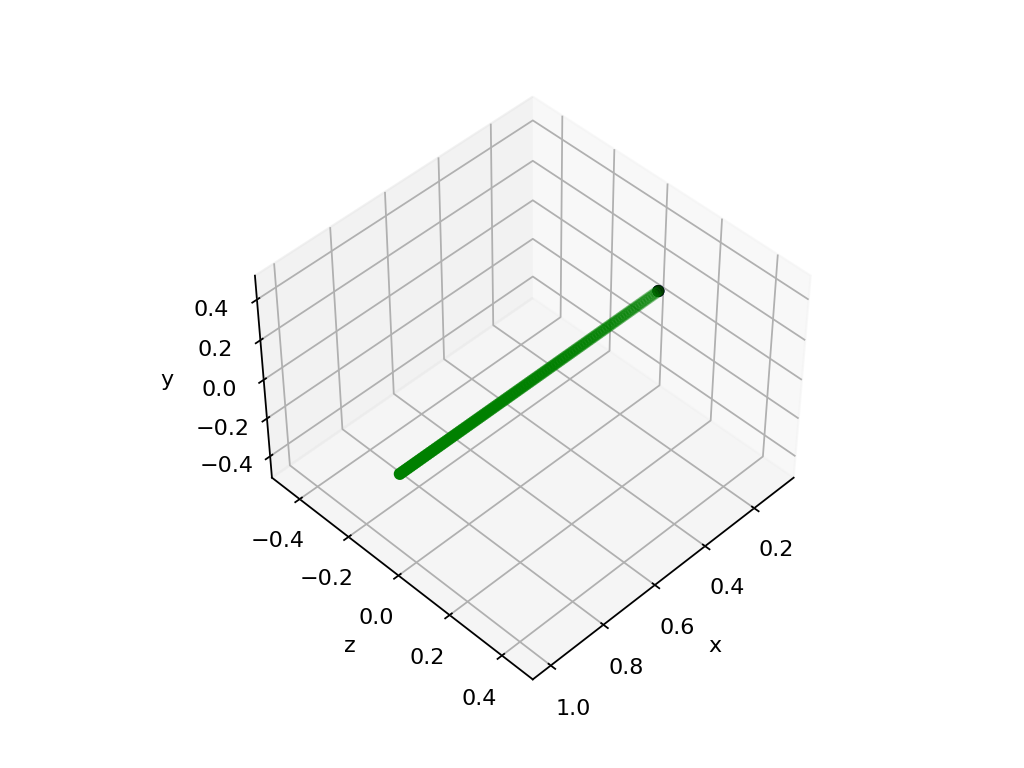

In [7]:
path_points =np.array( [
    env.init_pos*(1.0-t)+env.goal_pos*t for t in np.arange(0.0,1.0,1.0/100)

])
trajectory_points = env.trajectory_points
ax=plt.figure().add_subplot(111, projection = '3d')
X = path_points[:,0]
Y = path_points[:,1]
Z = path_points[:,2]
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_zlabel('y')
max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0
mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_z - max_range, mid_z + max_range)
ax.set_zlim(mid_y - max_range, mid_y + max_range)
ax.scatter3D(xs=X, zs=Y, ys=Z,c='g')
if trajectory_points!=None:
    ax.scatter3D(xs=[x[0] for x in trajectory_points],
        zs=[x[1] for x in trajectory_points],
        ys=[x[2] for x in trajectory_points],
        c=[[0,0,i/len(trajectory_points)] for i in range(len(trajectory_points))])
ax.view_init(elev=45,azim=45)#改变绘制图像的视角,即相机的位置,azim沿着z轴旋转，elev沿着y轴
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_zlabel('y')
# ax.scatter(env.path_start[0],env.path_start[2],env.path_start[1])
# ax.scatter(env.goal_pos[0],env.goal_pos[2],env.goal_pos[1])
# ax.scatter(env.body_xyz[0],env.body_xyz[2],env.body_xyz[1])
# ax.scatter(env.proj_pt_world[0],env.proj_pt_world[2],env.proj_pt_world[1])
plt.show()

In [8]:
def plot_infos(infos,title=None,reward_fig_name=None):
    dd = {k:[] for k in infos[0].keys()}
    for info in infos:
        for k in info.keys():
            dd[k].append(info[k])
    plt.figure()
    for k in dd.keys():
        if k=='action_penality':
            plt.plot(np.arange(0,len(dd[k])),[kkk  for kkk in dd[k]],label=k)
        else:
            plt.plot(np.arange(0,len(dd[k])),dd[k],label=k)
    plt.legend()
    if(title):
        plt.title(title)
    if(reward_fig_name):
        plt.savefig(reward_fig_name)
    plt.show()

In [9]:
from matplotlib.patches import FancyArrowPatch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D
class Arrow3D(FancyArrowPatch):
    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._xyz = (x,y,z)
        self._dxdydz = (dx,dy,dz)

    def draw(self, renderer):
        x1,y1,z1 = self._xyz
        dx,dy,dz = self._dxdydz
        x2,y2,z2 = (x1+dx,y1+dy,z1+dz)

        xs, ys, zs = proj_transform((x1,x2),(y1,y2),(z1,z2), renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        super().draw(renderer)
def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''
    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)
setattr(Axes3D,'arrow3D',_arrow3D)

In [10]:
def plot_env(env,ax):
    ax.clear()
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_z - max_range, mid_z + max_range)
    ax.set_zlim(mid_y - max_range, mid_y + max_range)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.view_init(elev=45,azim=45)#改变绘制图像的视角,即相机的位置,azim沿着z轴旋转，elev沿着y轴

    dp_local = np.dot(env.world_to_local,np.transpose(env.goal_pos-env.body_xyz))
    dxyz = dp_local
    fwd = env.simulator.rigid_solver.get_agent(0).fwd_axis
    right = env.simulator.rigid_solver.get_agent(0).right_axis
    up = env.simulator.rigid_solver.get_agent(0).up_axis
    ax.arrow3D(env.body_xyz[0],env.body_xyz[2],env.body_xyz[1],fwd[0],fwd[2],fwd[1],arrowstyle="-|>",ec ='green',mutation_scale=20,
           fc='red')
    ax.arrow3D(env.body_xyz[0],env.body_xyz[2],env.body_xyz[1],right[0],right[2],right[1],arrowstyle="-|>",ec ='green',mutation_scale=20,
           fc='green')
    ax.arrow3D(env.body_xyz[0],env.body_xyz[2],env.body_xyz[1],up[0],up[2],up[1],arrowstyle="-|>",ec ='green',mutation_scale=20,
           fc='blue')
    ax.arrow3D(env.body_xyz[0],env.body_xyz[2],env.body_xyz[1],dxyz[0],dxyz[2],dxyz[1],arrowstyle="-|>",)
    if env.trajectory_points!=None:
        ax.scatter3D(xs=[x[0] for x in env.trajectory_points],
            zs=[x[1] for x in env.trajectory_points],
            ys=[x[2] for x in env.trajectory_points],
            c=[[0,0,i/len(env.trajectory_points)] for i in range(len(env.trajectory_points))])
    fig.canvas.draw()
#     plt.show()
#     plt.pause(0.0001)

In [11]:
action_dim = env.action_space.low.shape[0]

zsh:1: 权限不够: ./clean_visdata.sh


<IPython.core.display.Javascript object>


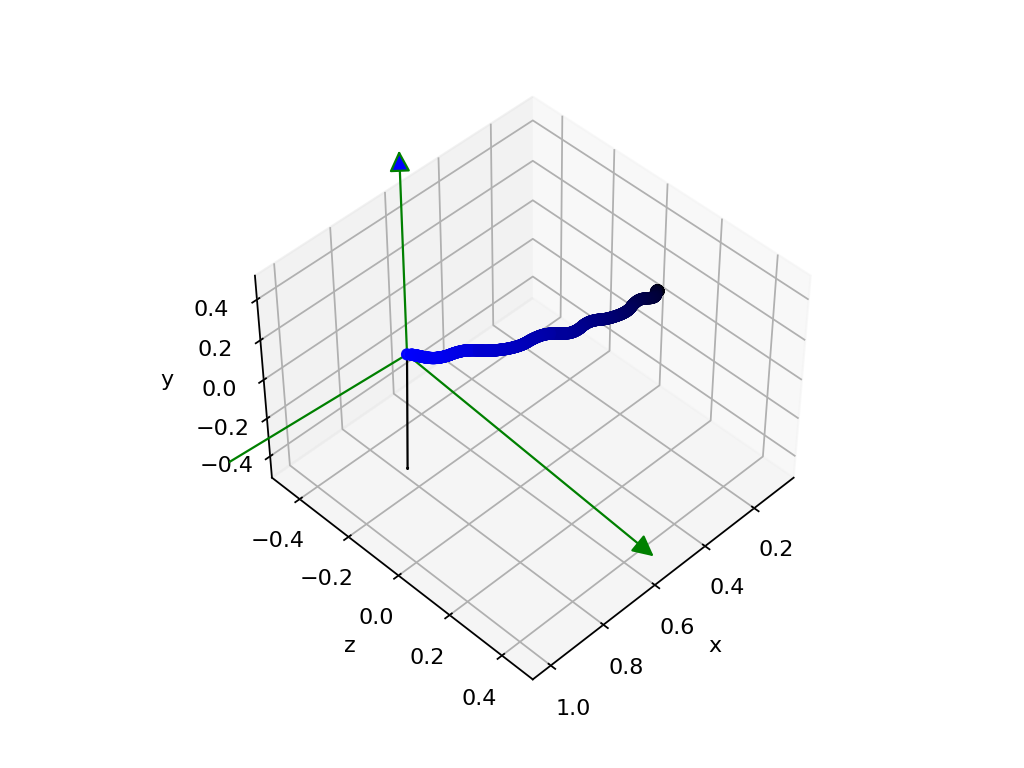

<ipython-input-9-449aeb0b9c3e>:16: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj_transform((x1,x2),(y1,y2),(z1,z2), renderer.M)


14.363142728805542 2.800018787384033


In [12]:
!./clean_visdata.sh
import random
for i in range(1):
    env.reset()
    # env.rigid_data.skeletons[0].dynamics.getJoint("head").setVelocity(0,0)
    # env.rigid_data.skeletons[0].dynamics.getJoint("head").setVelocity(1,0.)
    # joint_list =['spine','spine01','spine02','spine03']
    # for jnt_name in joint_list:
    #     env.rigid_data.skeletons[0].dynamics.getJoint(jnt_name).setPosition(0,0)
    #     env.rigid_data.skeletons[0].dynamics.getJoint(jnt_name).setVelocity(0,0)
    # env.rigid_data.skeletons[0].dynamics.update()
    # env.set_task(0,0.01)
    start_time = time.time()
    env.training=True
    done = False
    infos = []

    vels = []
    linear_accels = []
    angular_accels = []
    joint_accels=[]
    actions = []
    rewards = []
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    plt.ion()
    while not done :
        act = math.sin(6.28*2*env.simulator.time)
        aaa =  np.ones(int(action_dim))*act*2
        aaa[-1]=0
#         aaa = np.concatenate((np.ones(int(env.action_dim/2))*act,-np.ones(int(env.action_dim/2))*act))
        obs,r,done,info=env.step(aaa)
        rewards.append(r)
    #     vels.append(env.rigid_data.skeletons[0].dynamics.getBaseLink().getLinearVelocity())
    #     linear_accels.append(env.rigid_data.skeletons[0].dynamics.getBaseLink().getLinearAcceleration())
    #     angular_accels.append(env.rigid_data.skeletons[0].dynamics.getBaseLink().getAngularAcceleration())
    #     joint_accels.append(env.rigid_data.skeletons[0].dynamics.getJoint("head").getAccelerations())
        plot_env(env,ax)
        infos.append(info)
#     plt.close(fig)
#     env.plot3d()
    # plot_infos(infos)
    end_time = time.time()
    print(end_time-start_time,env.simulator.time)

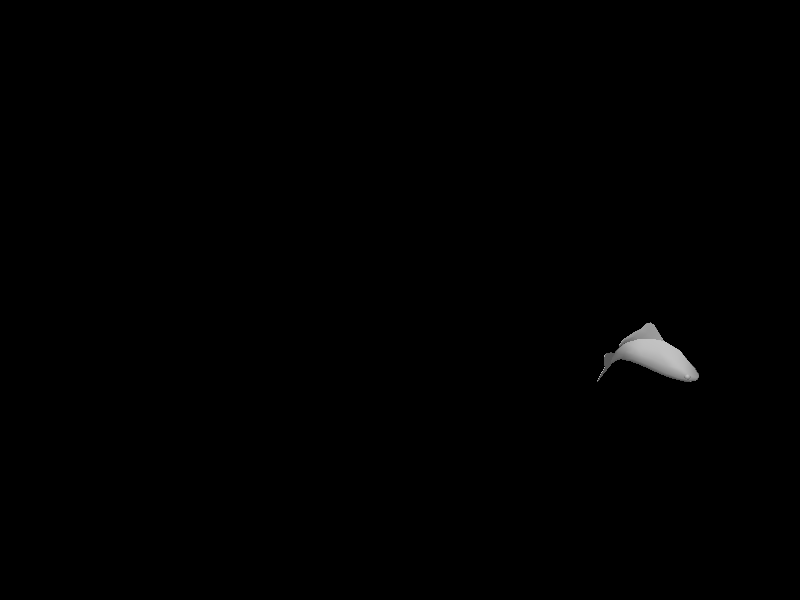

In [13]:
arr = env.render(mode='rgb_array')
from PIL import Image
Image.fromarray(arr)

<IPython.core.display.Javascript object>


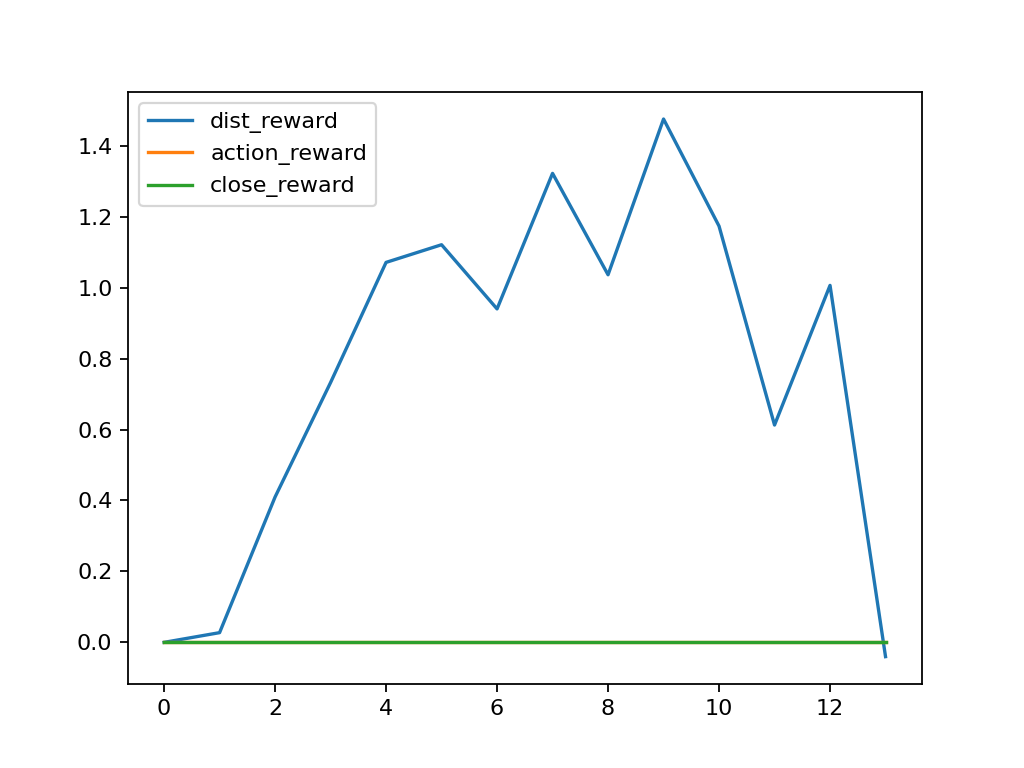

In [14]:
plot_infos(infos)

<IPython.core.display.Javascript object>


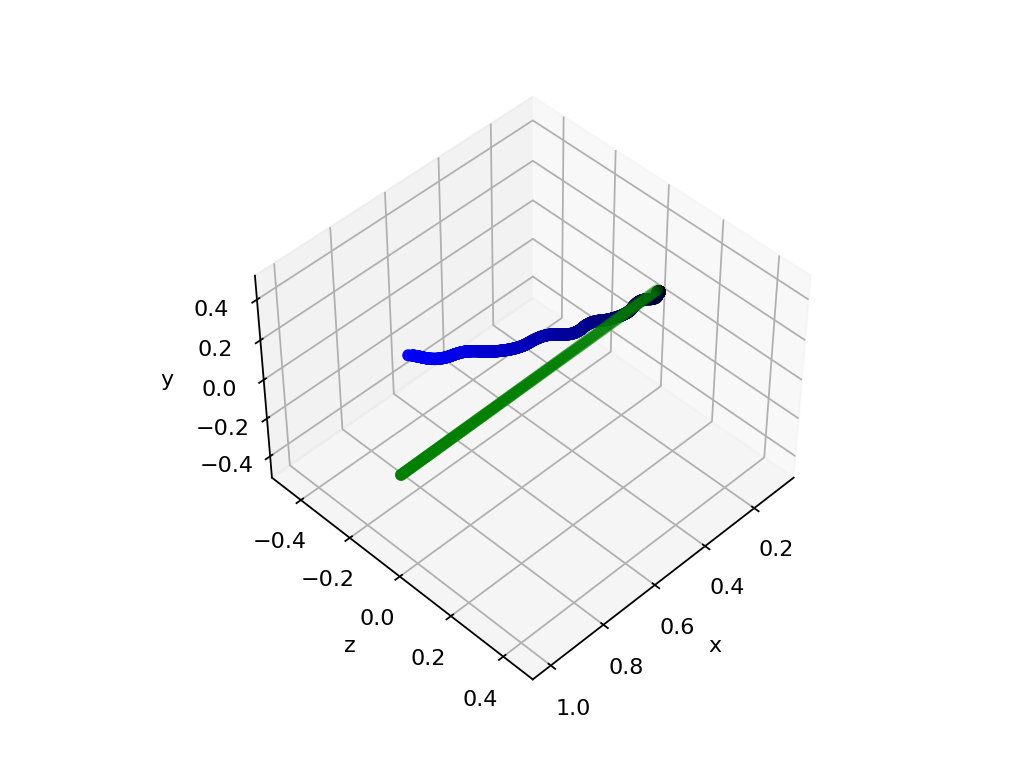

In [15]:
env.plot3d()

In [16]:
env.simulator.rigid_solver.get_agent(0).com

array([ 0.72506075,  0.        , -0.31245375])

In [17]:
obs

array([ 8.16737824e-01,  3.11909120e-01,  0.00000000e+00,  3.32098717e-01,
       -2.19410411e-02,  0.00000000e+00,  3.08342610e-01,  3.01384040e-01,
        0.00000000e+00, -3.01459504e-01,  2.68586931e-01,  5.01247709e-01,
        1.08856710e+00,  1.00564207e+00,  8.65953792e-02,  1.14877237e-09,
        2.23309861e-09,  2.82660508e-09,  4.18322479e-09,  5.06267028e-10])

In [18]:
env.dist_to_path

0.3091222645573951